# Stability of sentences

## 1 Setup

Setup the database

In [1]:
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Imports for the analysis

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from pandas import DataFrame
from scipy.stats import linregress
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip models with useful tools

In [3]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Stability of sentences

First generate our data

In [4]:
trees = Tree.objects.experiment.all()
data = []
order = []
for tree in trees:
    root = tree.root
    order.append({'tree id': tree.id,
                  'root_content_words_count': len(root.content_words)})
    for sentence in tree.sentences.kept.all():
        length = len(sentence.content_words)
        rate = np.array([sentence.ordered_content_distance(child, normalized=False) / length
                         for child in sentence.children.kept.all()]).mean()
        data.append({'tree id': tree.id,
                     'sentence id': sentence.id,
                     'length': length,
                     'length / len(root)': length / len(root.content_words),
                     'depth': sentence.depth,
                     'distance to root': \
                         root.ordered_content_distance(sentence, normalized=False) / \
                             len(root.content_words),
                     'change rate': rate})
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root_content_words_count', 'tree id'])

/home/sl/.virtualenvs/spreadr/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)

  warnings.warn("Mean of empty slice.", RuntimeWarning)



### 2.1 Quick look at the interactions between change rate, length, depth

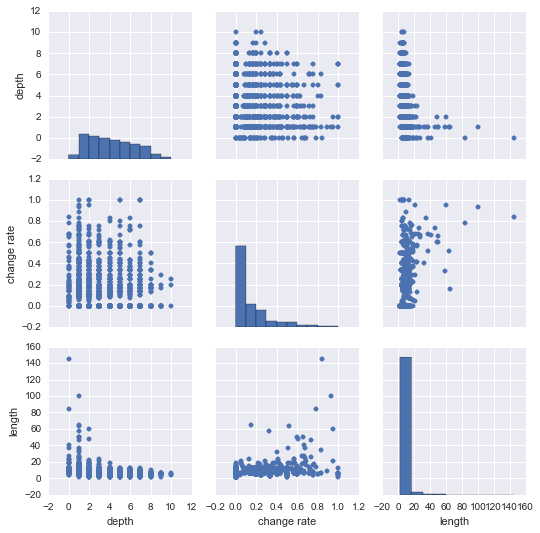

In [5]:
sb.pairplot(data=data.dropna(how='any'), vars=['depth', 'change rate', 'length']);

Now restricting to sentences with less than 15 content words:

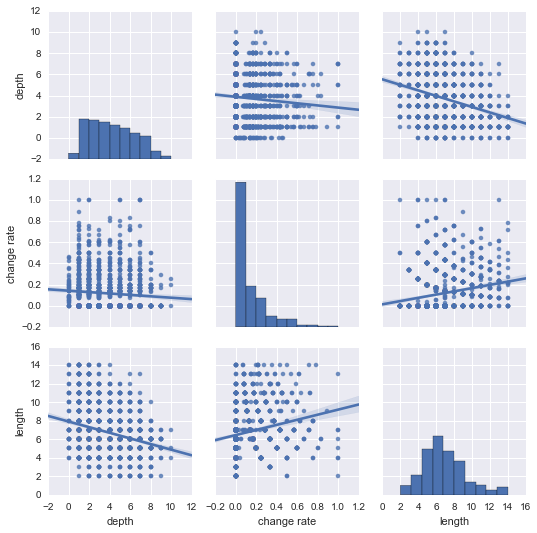

In [6]:
sb.pairplot(data=data[data['length'] < 15].dropna(how='any'),
            vars=['depth', 'change rate', 'length'], kind='reg');

### 2.2 At fixed sentence length, how does change rate depend on depth?

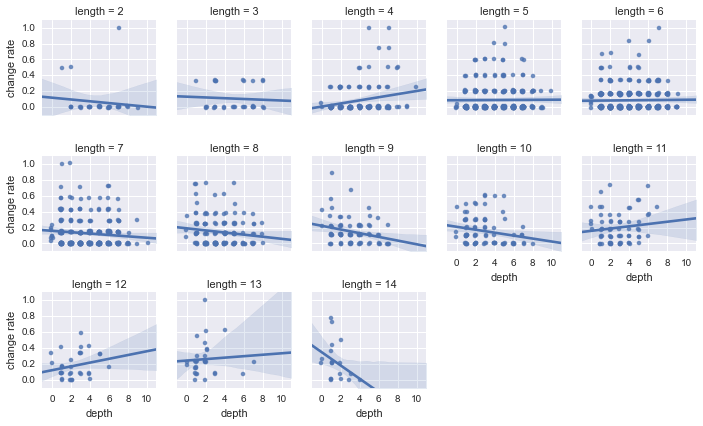

In [7]:
g = sb.lmplot(data=data[data['length'] < 15].dropna(how='any'), x='depth', y='change rate',
              col='length', col_wrap=5, size=2, col_order=range(min(data['length']), 15),
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1));

And the same data with hexbins:

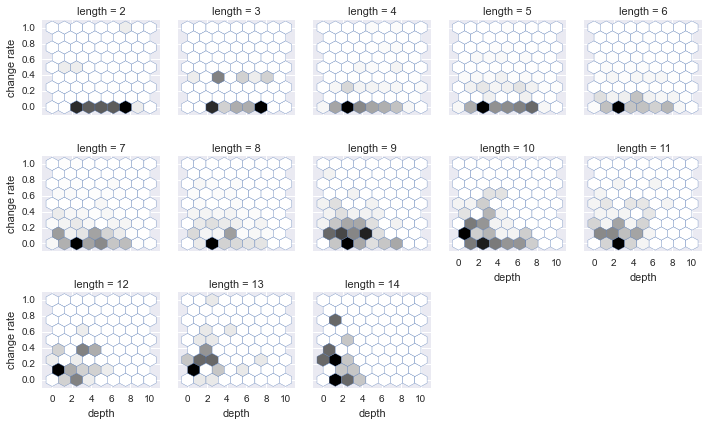

In [8]:
g = sb.FacetGrid(data[data['length'] < 15].dropna(how='any'), col='length',
                 col_wrap=5, size=2, col_order=range(min(data['length']), 15))
g.map(plt.hexbin, 'depth', 'change rate', gridsize=8, extent=(0, 10, 0, 1))
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1));

### 2.3 How do trees behave with change rate ~ depth?

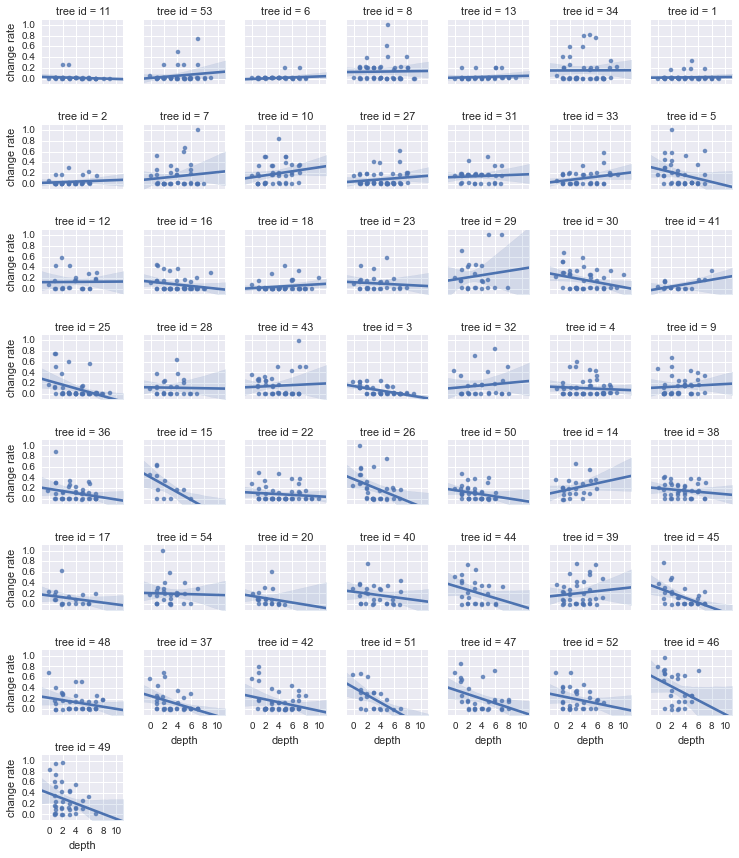

In [9]:
g = sb.lmplot(data=data.dropna(how='any'),
              x='depth', y='change rate',
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'],
              x_jitter=.1, y_jitter=.01)
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
g.savefig('/home/sl/Downloads/gistr/change-rate_depth.png', dpi=300)

### 2.4 How do trees behave with length ~ depth?

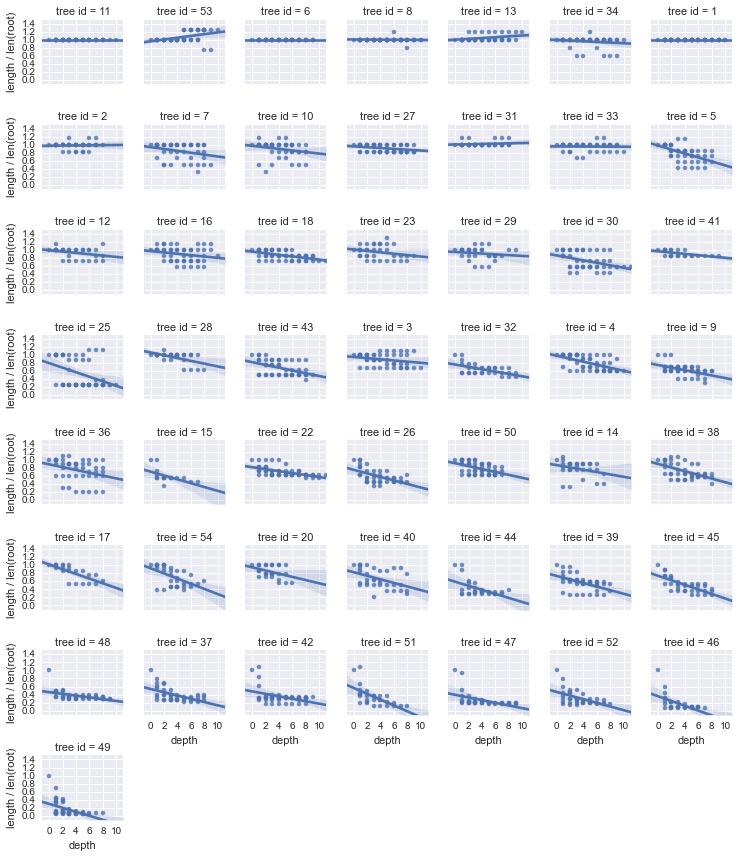

In [10]:
g = sb.lmplot(data=data,
              x='depth', y='length / len(root)',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.5))
g.savefig('/home/sl/Downloads/gistr/length_depth.png', dpi=300)

In [11]:
print(Tree.objects.get(id=53).root.text)
print(Tree.objects.get(id=53).root.content_words)

He promised he'd be on time for the party tonight
['promis', 'time', 'parti', 'tonight']


In [12]:
[s.content_words for s in Tree.objects.get(id=53).sentences.kept.all()]

[['promis', 'would', 'time'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'night'],
 ['promis', 'll', 'time', 'parti', 'tonight'],
 ['promis', 'would', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'night'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'hed', 'time', 'part', 'thonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time', 'parti', 'tonight'],
 ['promis', 'time'

In [13]:
print(Tree.objects.get(id=13).root.text)
print(Tree.objects.get(id=13).root.content_words)

Dinosaurs and humans walked the earth at the same time
['dinosaur', 'human', 'walk', 'earth', 'time']


In [14]:
[s.content_words for s in Tree.objects.get(id=13).sentences.kept.all()]

[['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaura', 'human', 'walk', 'earth', 'time'],
 ['dinosor', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'world', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'exact', 'time'],
 ['dinosaur', 'human', 'walk', 'earth', 'time'],
 ['din

### 2.5 How do trees behave with distance to root ~ depth?

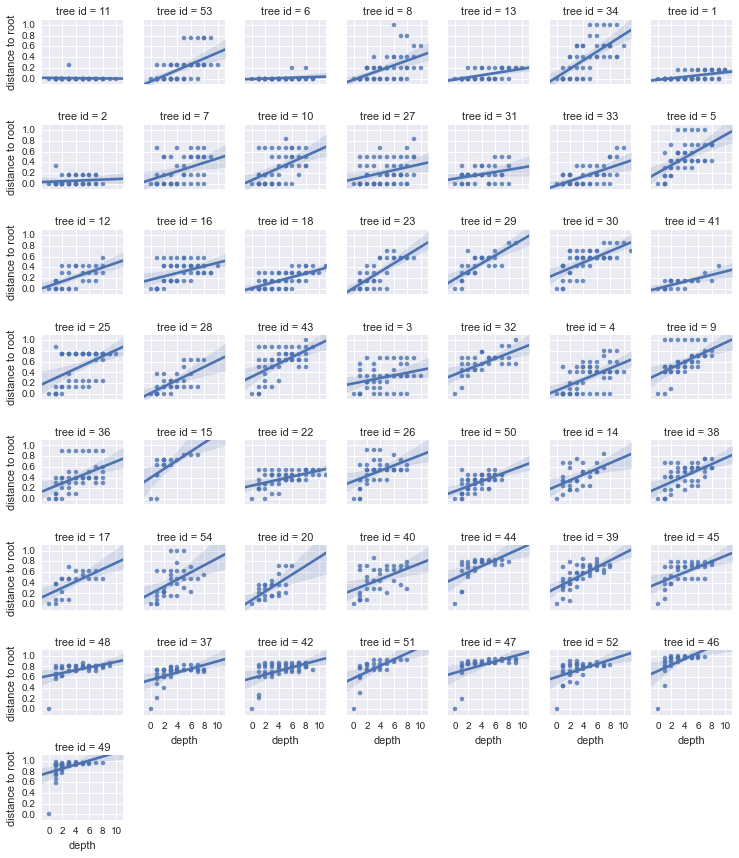

In [15]:
g = sb.lmplot(data=data,
              x='depth', y='distance to root',
              sharex=True, sharey=True,
              col='tree id', col_wrap=7, size=1.5,
              col_order=root_order['tree id'])
g.set(xlim=(-1, 11), ylim=(-0.1, 1.1))
g.savefig('/home/sl/Downloads/gistr/distance-to-root_depth.png', dpi=300)